# My question is what percentage of good articles on the English Wikipedia have a "See also" section, as compared to featured articles.
# First, let's collect the URLs of every good/featured article on the English wikipedia.
# There are approximately 43,000 good articles and 7,000 featured articles out of approximately 7,000,000 total articles on the English Wikipedia.
# For information on what constitutes a good/featured article, see en.wikipedia.org/wiki/WP:GACR and en.wikipedia.org/wiki/WP:FACR

In [1]:
import requests
import pandas as pd
import random as rand
import math
import scipy.stats as st
import matplotlib.pyplot as plt

url = "https://en.wikipedia.org/w/api.php"
headers = {
    "User-Agent": "StatisticsEducationBot/1.0 (Statistics Class Project; educational use)"
}
session = requests.Session()

def get_category_articles(category_name):
    params = {
        "action": "query",
        "list": "categorymembers",
        "cmtitle": category_name,
        "cmlimit": 500,
        "format": "json"
    }

    all_titles = []
    continue_token = True

    while continue_token:
        response = session.get(url=url, params=params, headers=headers)
        data = response.json()
        for page in data["query"]["categorymembers"]:
            all_titles.append(page["title"])

        if "continue" in data:
            params["cmcontinue"] = data["continue"]["cmcontinue"]
        else:
            continue_token = False
    
    return pd.DataFrame(all_titles, columns=["title"])

# Get good articles
df_good = get_category_articles("Category:Good articles")

# Get featured articles
df_featured = get_category_articles("Category:Featured articles")

# Now, let's create a function for analysis, using a sample size of 200 articles total for each category and binning into samples of 5 to create the histogram.

In [2]:
def analyze_articles(df, total_articles=200, sample_size=5, search_for="== See also =="):
    found = 0
    found_in_window = 0
    proportions = []
    titles = df['title'].tolist()

    for article in range(total_articles):
        if not titles:
            break
        # Select a random article title without replacement
        article_title = titles.pop(rand.randrange(len(titles)))

        params = {
            "action": "query",
            "titles": article_title,
            "prop": "extracts",
            "explaintext": True,
            "format": "json"
        }

        data = session.get(url=url, params=params, headers=headers).json()
        pages = data['query']['pages']
        page_id = list(pages.keys())[0]
        content = pages[page_id].get('extract', 'No content available')

        if search_for in content:
            found += 1
            found_in_window += 1
        
        if article % sample_size == (sample_size - 1):
            proportions.append(found_in_window / sample_size)
            found_in_window = 0

    prob = found / total_articles
    z_score = st.norm.ppf(1 - (1 - 0.95) / 2)
    variance = prob * (1 - prob) / total_articles
    fpc = (len(df) - total_articles) / (len(df) - 1)
    error_1 = math.sqrt(variance)
    error_2 = math.sqrt(variance * fpc)
    moe_1 = z_score * error_1
    moe_2 = z_score * error_2

    print(f"Percent of articles that contain a '{search_for}' section:", prob)
    print("Uncorrected standard error:", error_1)
    print("Corrected standard error:", error_2)
    print("Uncorrected margin of error:", moe_1)
    print("Corrected margin of error:", moe_2)
    print(f"Corrected 95 percent confidence interval: ({prob - moe_2}, {prob + moe_2})")

    # Plot histogram
    plt.hist(proportions, bins=6, range=(-0.1,1.1), edgecolor='black', alpha=0.7)
    plt.title(f'Histogram of Proportions of Articles with "{search_for}" Section')
    plt.xlabel(f'Proportion in Sample Window (Sample Size = {sample_size})')
    plt.ylabel('Frequency')
    plt.grid(axis='y', alpha=0.75)
    plt.xlim(-0.1, 1.1)
    plt.ylim(0, 14)
    plt.show()

# Now, here's our analysis:

---- Good Articles ----
Percent of articles that contain a '== See also ==' section: 0.38
Uncorrected standard error: 0.03432200460346103
Corrected standard error: 0.03424262973859885
Uncorrected margin of error: 0.06726989290000156
Corrected margin of error: 0.06711432102359395
Corrected 95 percent confidence interval: (0.31288567897640607, 0.44711432102359394)


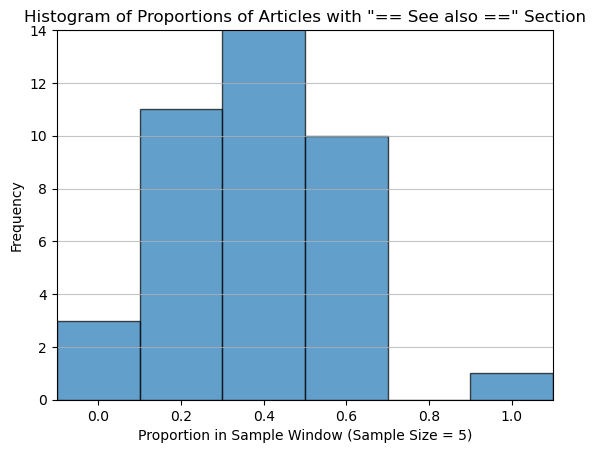


---- Featured Articles ----
Percent of articles that contain a '== See also ==' section: 0.4
Uncorrected standard error: 0.034641016151377546
Corrected standard error: 0.034132332396936575
Uncorrected margin of error: 0.06789514404457031
Corrected margin of error: 0.06689814220634538
Corrected 95 percent confidence interval: (0.33310185779365464, 0.4668981422063454)


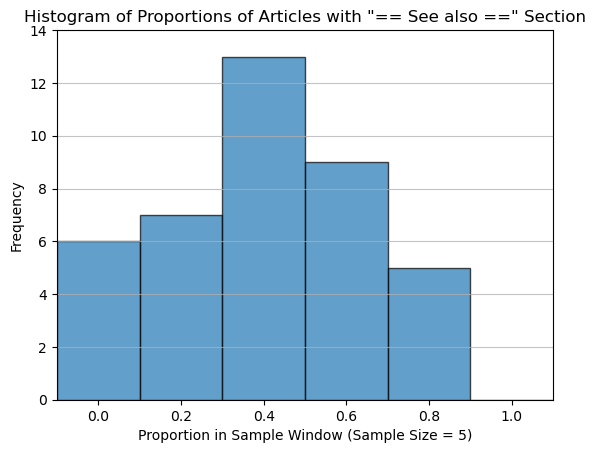

In [3]:
print("---- Good Articles ----")
analyze_articles(df_good)

print("\n---- Featured Articles ----")
analyze_articles(df_featured)

# In conclusion, it appears that approximately 38.0% of good articles and 40.0% of featured articles on the English Wikipedia contain a "See also" section.
# The margin of error for 95% confidence (after applying the finite population correction) was approximately 6.7% for both categories.
# This makes us 95% confident that the true percentage is between 31.3% and 44.7% for good articles, and between 33.3% and 46.7% for featured articles.
# The confidence intervals for both categories overlap significantly, so I cannot definitively conclude that featured articles are more likely to contain a "See also" section.
# The distributions are likely not normal according to the histograms, but the low sample size makes this uncertain. The margin of error and confidence interval may be incorrect.